# CITS5508 - Lab04

### Wenxiao Zhang (22792191)

In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVR
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR


## Project 1

### Section 1

### 1.1 Read in the contents of the file

In [2]:
slump_test_data = pd.read_csv('slump_test.data')

### 1.2 Inspect the data

In [3]:
slump_test_data.head()

,No,Cement,Slag,Fly ash,Water,SP,Coarse Aggr.,Fine Aggr.,SLUMP(cm),FLOW(cm),Compressive Strength (28-day)(Mpa)
0,1,273.0,82.0,105.0,210.0,9.0,904.0,680.0,23.0,62.0,34.99
1,2,163.0,149.0,191.0,180.0,12.0,843.0,746.0,0.0,20.0,41.14
2,3,162.0,148.0,191.0,179.0,16.0,840.0,743.0,1.0,20.0,41.81
3,4,162.0,148.0,190.0,179.0,19.0,838.0,741.0,3.0,21.5,42.08
4,5,154.0,112.0,144.0,220.0,10.0,923.0,658.0,20.0,64.0,26.82


In [4]:
print(slump_test_data.shape)
slump_test_data.info()

(103, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 11 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   No                                  103 non-null    int64  
 1   Cement                              103 non-null    float64
 2   Slag                                103 non-null    float64
 3   Fly ash                             103 non-null    float64
 4   Water                               103 non-null    float64
 5   SP                                  103 non-null    float64
 6   Coarse Aggr.                        103 non-null    float64
 7   Fine Aggr.                          103 non-null    float64
 8   SLUMP(cm)                           103 non-null    float64
 9   FLOW(cm)                            103 non-null    float64
 10  Compressive Strength (28-day)(Mpa)  103 non-null    float64
dtypes: float64(10), int64(1)
memory usa

We can see that there is no NA value exists in the dataset. And from the description of the dataset we can know that the column `No` is neither input features nor output features, which means it should be removed.

### 1.3 Data visualization

We will visualize the input features of the dataset to see if we need to remove any of them. We do this by visualizing their distributions and corelations between each other. If the correlation value between any two features is too high, we may decide to remove one of this two features.

The following scatter matrix visualizes the bivariate relationship between different combinations of features. 

In [5]:
# select input features
input_features = ['Cement', 'Slag', 'Fly ash', 'Water', 'SP', 'Coarse Aggr.',
                  'Fine Aggr.']

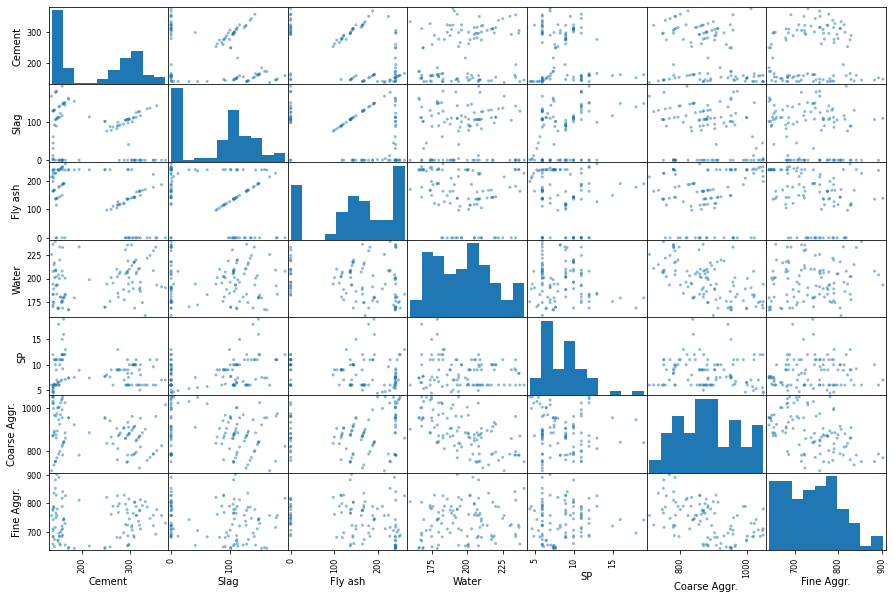

In [6]:
# scatter matrix plot
scatter_matrix(slump_test_data[input_features], figsize=(15, 10))
plt.show()

We can see from the graphs on the diagonal of `scatter_matrix` that every feature column have relatively proper distributions (basically not been skewed on one side). And there is no obvious correlation seen between any two features when looking at these scattered plots in the matrix. We will use `heatmap` to take a further look at their correlations.

The following `heatmap` plot shows the correlations of each feature with others. We can see that the correlation values are all not very high (above 0.8), which means we may not have to remove any feature columns in the dataset.

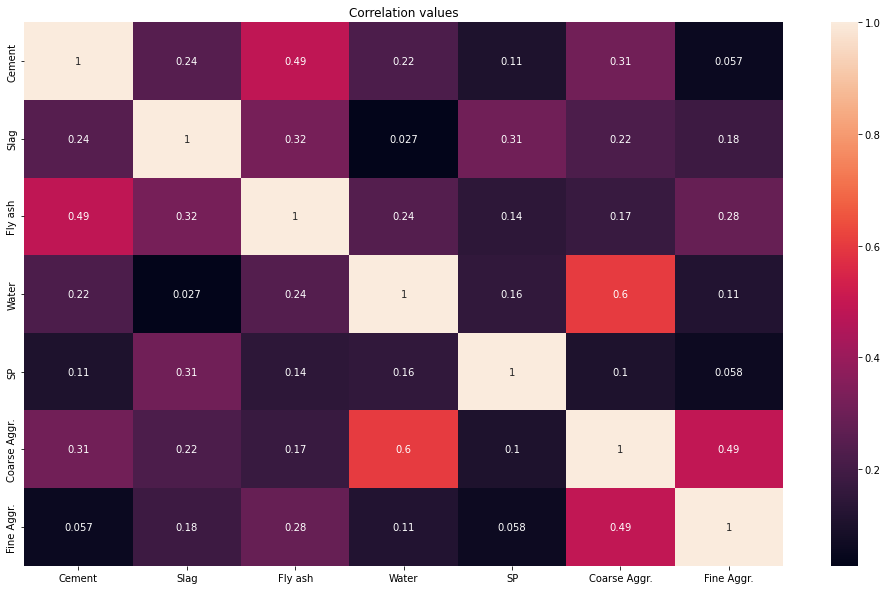

In [7]:
# heatmap plot
plt.figure(figsize=(17, 10))
sns.heatmap(slump_test_data[input_features].corr().abs(), annot=True)
plt.title('Correlation values')
plt.show()

### 1.4 Perform data cleaning

The data cleaning function takes threshold of the correlation value as the input parameter to determine which columns should be removed. We set the threshold = 0.8 by default, which means no feature will be removed in this case. The output of the function is a dataframe after the cleaning procedure.

In [8]:
# threshold: the threshold of the correlation values
def clean_slump(threshold = 0.8):
    inputs = ['Cement', 'Slag', 'Fly ash', 'Water', 'SP', 'Coarse Aggr.',
              'Fine Aggr.']
    # drop two output columns and 'No' (neither non-feature nor non-output)
    df = slump_test_data.drop(columns=['SLUMP(cm)', 'FLOW(cm)', 'No'])
    corrs = df[inputs].corr().values
    # get the feature name
    features = list(df[inputs].columns)
    for i in range(len(corrs)):
        # traverse the correlations on one side
        for j in range(i+1, len(corrs[i])):
            # remove one from the pair which has the higher correlation value
            if abs(corrs[i][j]) >= threshold:
                df = df.drop(columns=[features[i]])
    return df

# we use default threshold to call the function
slump_test = clean_slump()


### Section 2

### 2.1 Perform 80/20 random split on the dataset

In [9]:
output = 'Compressive Strength (28-day)(Mpa)'
# select input features
X_slump = slump_test.drop(columns=[output])
# select output
y_slump = slump_test[output]
# split train set and test set
X_train_slump, X_test_slump, y_train_slump, y_test_slump = train_test_split(
    X_slump, y_slump, test_size=0.2, random_state=42)

### 2.2 Feature scaling

In order to improve the performance of each model and avoid convergence problem, we perform feature scaling before training the model.

In [10]:
# instantiate the standard scaler
scaler = StandardScaler()
# perform feature scaling
X_train_slump = scaler.fit_transform(X_train_slump)
X_test_slump = scaler.transform(X_test_slump)

### 2.2 SVM regressor

For this regressor, we want to tune the regularization parameter `C` to adjust the weight and bias of the model. We also want to adjust the parameter `epsilon` to adjust the margin of error tolerance of the model. On top of that, we want to adjust the parameter `loss` to find the suitable loss function. We do these by applying grid search with 3-fold validation to find the best combination of the parameters of SVM regressor.

In [11]:
# hyperparameter tuning
param_grid_svm = [{'C':[0.1, 1, 10], 'epsilon': [0, 0.5, 1], 'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive']}]
grid_search_svm = GridSearchCV(LinearSVR(random_state=42, max_iter=10000), param_grid_svm, cv=3)
grid_search_svm.fit(X_train_slump, y_train_slump)
print(grid_search_svm.best_params_)
# select the best estimator from the grid search
svm_reg = grid_search_svm.best_estimator_

{'C': 10, 'epsilon': 0, 'loss': 'squared_epsilon_insensitive'}


### 2.3 Linear regressor

We will set `fit_intercept=True` to calculate the intercept for this model.

In [12]:
lin_reg = LinearRegression(fit_intercept=True)
# train the linear regressor model with the training set
lin_reg.fit(X_train_slump, y_train_slump)

LinearRegression()

### 2.4 Stochastic Gradient Descent regressor

For this regressor, we want to tune the hyperparamters related to learning rates. So we will tune the learning rate schedule `learning_rate` and the initial learning rate `eta0` by applying grid search with 3-fold validation to find the best combination of the parameters of SGD regressor.

In [13]:
# hyperparameter tuning
param_grid_sgd = [{'learning_rate': ['constant','optimal', 'invscaling'], 'eta0': [0.001, 0.01, 0.1]}]
grid_search_sgd = GridSearchCV(SGDRegressor(
    random_state=42, max_iter=10000), param_grid_sgd, cv=3)
grid_search_sgd.fit(X_train_slump, y_train_slump)
print(grid_search_sgd.best_params_)
# select the best estimator from the grid search
sgd_reg = grid_search_sgd.best_estimator_

{'eta0': 0.01, 'learning_rate': 'constant'}


### 2.5 Voting regressor

The Voting regressor is built and trained by taking `SVM regressor`, `linear regressor`, and `SGD regressor` trained above.

In [14]:
vr = VotingRegressor([('svmr',svm_reg), ('linr',lin_reg),('sgdr',sgd_reg)])
# train the voting regressor model with the training set
vr.fit(X_train_slump, y_train_slump)

VotingRegressor(estimators=[('svmr',
                             LinearSVR(C=10, epsilon=0,
                                       loss='squared_epsilon_insensitive',
                                       max_iter=10000, random_state=42)),
                            ('linr', LinearRegression()),
                            ('sgdr',
                             SGDRegressor(learning_rate='constant',
                                          max_iter=10000, random_state=42))])

### Section 3 

### 3.1 Perform predictions on the test set and caculate RMSE

Perform prediction by applying the models trained above. Using `X_test_slump` as the input parameter for each model to predict. Using `y_test_slump` as the ground truth values to caculate RMSE for each model.

In [15]:
# Perform predictions on the test set
svm_pred = svm_reg.predict(X_test_slump)
lin_pred = lin_reg.predict(X_test_slump)
sgd_pred = sgd_reg.predict(X_test_slump)
vr_pred = vr.predict(X_test_slump)

# caculate RMSE
print('RMSE for SVM Regressor: ' + str(mean_squared_error(
    y_test_slump, svm_pred, squared=False)))

print('RMSE for Linear Regressor: ' + str(mean_squared_error(
    y_test_slump, lin_pred, squared=False)))

print('RMSE for SGD Regressor: ' + str(mean_squared_error(
    y_test_slump, sgd_pred, squared=False)))

print('RMSE for Voting Regressor: ' + str(mean_squared_error(
    y_test_slump, vr_pred, squared=False)))


RMSE for SVM Regressor: 2.063805699469627
RMSE for Linear Regressor: 2.068522874433818
RMSE for SGD Regressor: 2.065563895007595
RMSE for Voting Regressor: 2.063829156737368


We can see from the output that the RMSE values for each model are very close, which means these regressors have similar performance in predicting this dataset.

### 3.2 Compare the predicted values versus the ground truth values

We will use `lineplot` to visualize the distribution of predicted values of each model versus that of the ground truth values for all test instances. The x-axis is the reset index of each test instance, and the y axis is the value for predicted values and ground truth values.

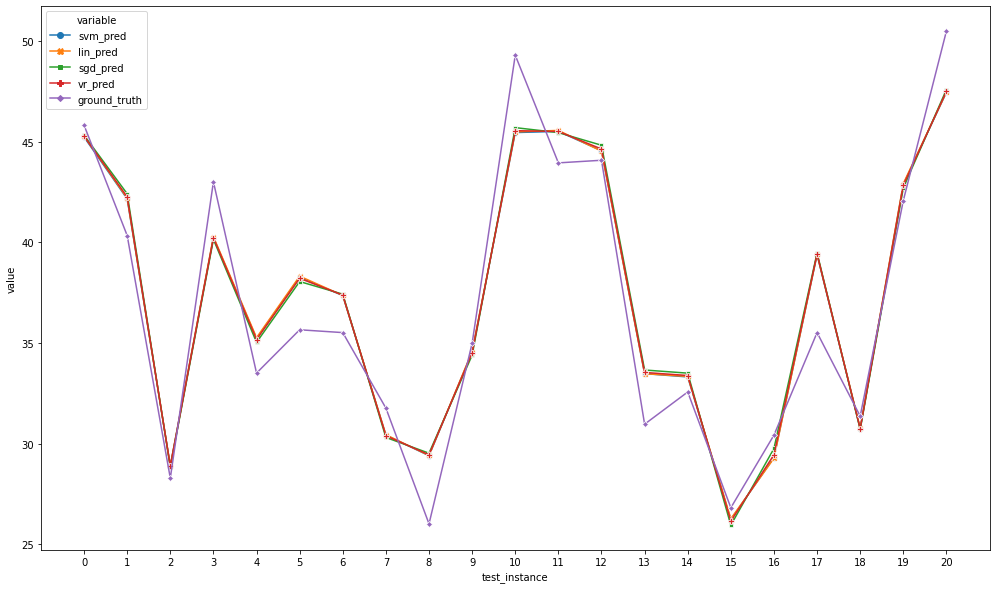

In [16]:
df_pred_truth = pd.DataFrame({'svm_pred': svm_pred, 'lin_pred': lin_pred, 'sgd_pred': sgd_pred,
                             'vr_pred': vr_pred, 'ground_truth': y_test_slump}).reset_index(drop=True)
df_pred_truth.reset_index(inplace=True)
df_pred_truth = df_pred_truth.rename(columns={'index': 'test_instance'})

df_pred_truth = df_pred_truth.melt(id_vars='test_instance')
df_pred_truth['test_instance'] = df_pred_truth['test_instance'].astype(str)
plt.figure(figsize=(17, 10))
sns.lineplot(data=df_pred_truth, x='test_instance',
             y='value', hue='variable', style='variable', markers=True, dashes=False)
plt.show()


From the output plot we can see that the distributions of the predicted values ​​of these models are highly overlapping, which means they all have similar prediction performance on this dataset. In addition, the distribution of ground truth values also have similar distribution with the predicted values in general, with some relatively obvious deviations for some `test_instance` such as `8`, `10`, `17`. This means all estimators have good performance in predicting this dataset in general.

## Project 2
### Section 1

### 1.1 Read in the contents of the file

In [17]:
abalone_data = pd.read_csv('abalone.data', names=['Sex', 'Length', 'Diameter',
                                                  'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings'])


### 1.2 Inspect the data

In [18]:
abalone_data.head()


,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [19]:
print(abalone_data.shape)
abalone_data.info()

(4177, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4177 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


We can see that this dataset also has no NA value exists, which means we do not have to deal with null values when performing data cleaning. But the data type of `Sex` column is non-numeric type, which means we need to perform encoding to convert it into numeric values. 


### 1.2.1 Data visualization

Use `scatter_matrix` to visualize the dataset to see the coorelations between each variable. 

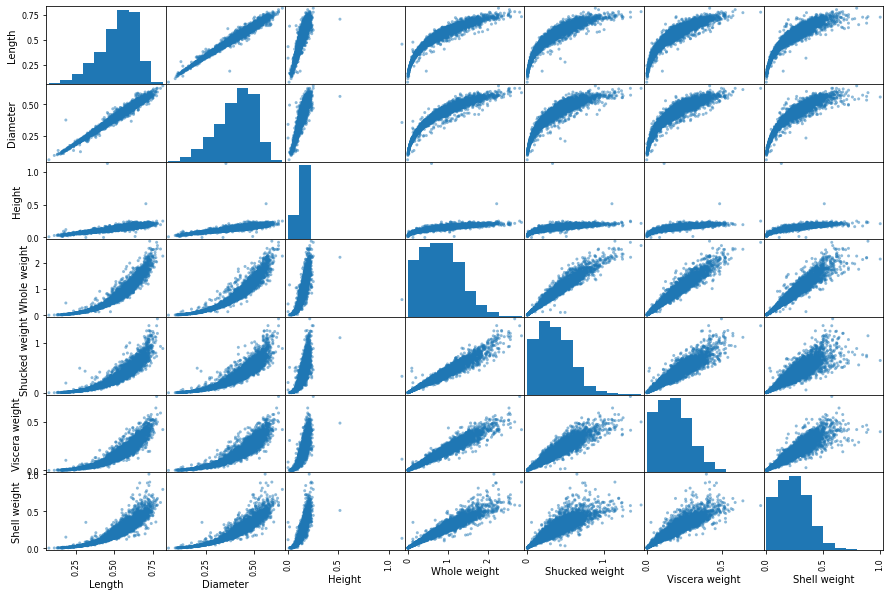

In [20]:
# scatter matrix plot
# input features
inputs = ['Sex', 'Length', 'Diameter',
          'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight']
scatter_matrix(abalone_data[inputs], figsize=(15, 10))
plt.show()

We can see that the distribution of the non-numeric variable `Sex` is generally divided into 3 parts, which suggests it may have 3 different categorical values in the dataset. In this case, we need to encode it into a dummy varible in the data preprocessing step. 

In addition, although other parameter pairs seem all have high correlations,  highly correlated variables won't cause multi-collinearity issues in random forest model, so we may leave them for now.

### 1.3 Perform data preprocessing
We will use `LabelEncoder` to encode `Sex` column to convert it into numeric values.

In [21]:
def preprocess_abalone():
    labelencoder = LabelEncoder()
    abalone_data['Sex'] = labelencoder.fit_transform(abalone_data['Sex'])
    return abalone_data
abalone = preprocess_abalone()

### 1.4 Perform 85/15 random split on the dataset

Use `train_test_split()` to split the dataset. Set `test_size = 0.15` to achieve 85/15 random split.

In [22]:
output = 'Rings'

X_abalone = abalone.drop(columns=[output])
y_abalone = abalone[output]
X_train_abalone, X_test_abalone, y_train_abalone, y_test_abalone = train_test_split(
    X_abalone, y_abalone, test_size=0.15, random_state=42)

### Section 2 Random Forest Regressor
Set the `random_state=42` and `n_estimators=500` for the random forest regressor model.

For `min_samples_leaf` is the minimum number of samples required to be at a leaf node, we set `min_samples_leaf=3` to avoid overfitting issue. 

For `max_features` is the number of features to consider for each split, as we want to consider all the features, we set it to auto by default. 

As `bootstrap` is the method for sampling data points, we set `bootstrap = True` for sampling with replacement. On top of that, we set `max_samples = 1000` to draw 1000 samples from the dataset to train each base estimator.

In [23]:
# train the model
rnd_reg = RandomForestRegressor(n_estimators=500, random_state=42, min_samples_leaf=3, max_features='auto', bootstrap=True, max_samples=1000).fit(
    X_train_abalone, y_train_abalone)


In [24]:
# prediction
rnd_pred = rnd_reg.predict(X_test_abalone)

# round each predicted value to the nearest integer
rnd_pred = [int(round(num, 0)) for num in rnd_pred]

# compute RMSE
rmse_rnd = mean_squared_error(
    y_test_abalone, rnd_pred, squared=False)

print('RMSE of the RF regressor with full-dimensional features: '+str(rmse_rnd))

RMSE of the RF regressor with full-dimensional features: 2.157291703968835


The RMSE of the model built with tuned hyperparameters is shown above.

### Section 3 Trim the feature dimension

Use `SelectFromModel` to select important features from the dataset. Set `threshold=0.05` to retain features whose importance value is above 5%.

In [25]:
# train the model
selector = SelectFromModel(estimator=rnd_reg, threshold=0.05).fit(X_train_abalone, y_train_abalone)

In [26]:
status = selector.get_support()

# a list to store the selected feature names
selected = []
# a list to store the removed feature names
removed = []

feature_importance = selector.estimator.feature_importances_

total_value = 0

for i in range(len(status)):
    if status[i]:
        # get the name of the selected features
        selected.append(inputs[i])
        # caculate total feature importance value
        total_value = total_value+feature_importance[i]
    else:
        # get the name of the removed features
        removed.append(inputs[i])

print("Threshold: " + str(selector.threshold_))
print("Selected features:")
print(selected)
print("Removed features:")
print(removed)
print('Total feature importance value: ' +str(total_value))


Threshold: 0.05
Selected features:
['Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight']
Removed features:
['Sex', 'Length', 'Diameter']
Total feature importance value: 0.884697167825019


We can see when the `threshold=0.05`, features whose importances are below the threshold were removed.

### Section 4 Train and predict Reduced-dimensional data

Create a new `RandomForestRegressor` model with the same parameters and use the selected features of the data to train the model.

In [27]:
# select the selected features for X_train and X_test
X_train_abalone_re = X_train_abalone[selected]
X_test_abalone_re = X_test_abalone[selected]
# train the model
rnd_reg_re = RandomForestRegressor(n_estimators=500, random_state=42, min_samples_leaf=3, max_features='auto', bootstrap=True, max_samples=1000).fit(
    X_train_abalone, y_train_abalone).fit(
    X_train_abalone_re, y_train_abalone)

In [28]:
# prediction
rnd_pred_re = rnd_reg_re.predict(X_test_abalone_re)

# round each predicted value to the nearest integer
rnd_pred_re = [int(round(num, 0)) for num in rnd_pred_re]

# compute RMSE
rmse_rnd_re = mean_squared_error(
    y_test_abalone, rnd_pred_re, squared=False)


print('RMSE of the RF regressor with reduced-dimensional features: '+str(rmse_rnd_re))


RMSE of the RF regressor with reduced-dimensional features: 2.1935820551907477


We can see the RMSE of the model in this case is `2.1935820551907477`, which is slightly higher than the model in the case of full-dimensional features `2.157291703968835`.
### Section 5 
### 5.1 Compare the performance
Caculate RMSE and MAE for the prediction of each regressor to compare the performance.

In [29]:
# compute MAE value for both models
mae_rnd = mean_absolute_error(y_test_abalone, rnd_pred)
mae_rnd_re = mean_absolute_error(y_test_abalone, rnd_pred_re)

rmse_rnd_list = [rmse_rnd, rmse_rnd_re]
mae_rnd_list = [mae_rnd, mae_rnd_re]
pd.DataFrame(data = {'RMSE':rmse_rnd_list, 'MAE':mae_rnd_list}, index=['Full-dimensional features', 'Reduced-dimensional features'])

,RMSE,MAE
Full-dimensional features,2.157292,1.451356
Reduced-dimensional features,2.193582,1.491228


We can see that the RMSE and MAE of the model using reduced-dimensional features are all slightly higher than that of the model using full-dimensional features, which means the model using full-dimensional features has higher performance.

### 5.2 Compute the average error

Compute the average error for each ring value for these two RF regressor models. We do this by computing the errors for each test instances and grouping the errors by ring values in order to compute the average errors of each ring value.

We will illustrate the prediction errors of all the test instance by using `barplot` to visualize the average errors of model with full-dimensional features and that of the model with reduced-dimensional features, with x axis represents each test instance and y axis represents the value of average error. 

In order to see the relationship between the number of training instances and the value of average error, we draw another `barplot` to visualize the number of training instances for each ring value.

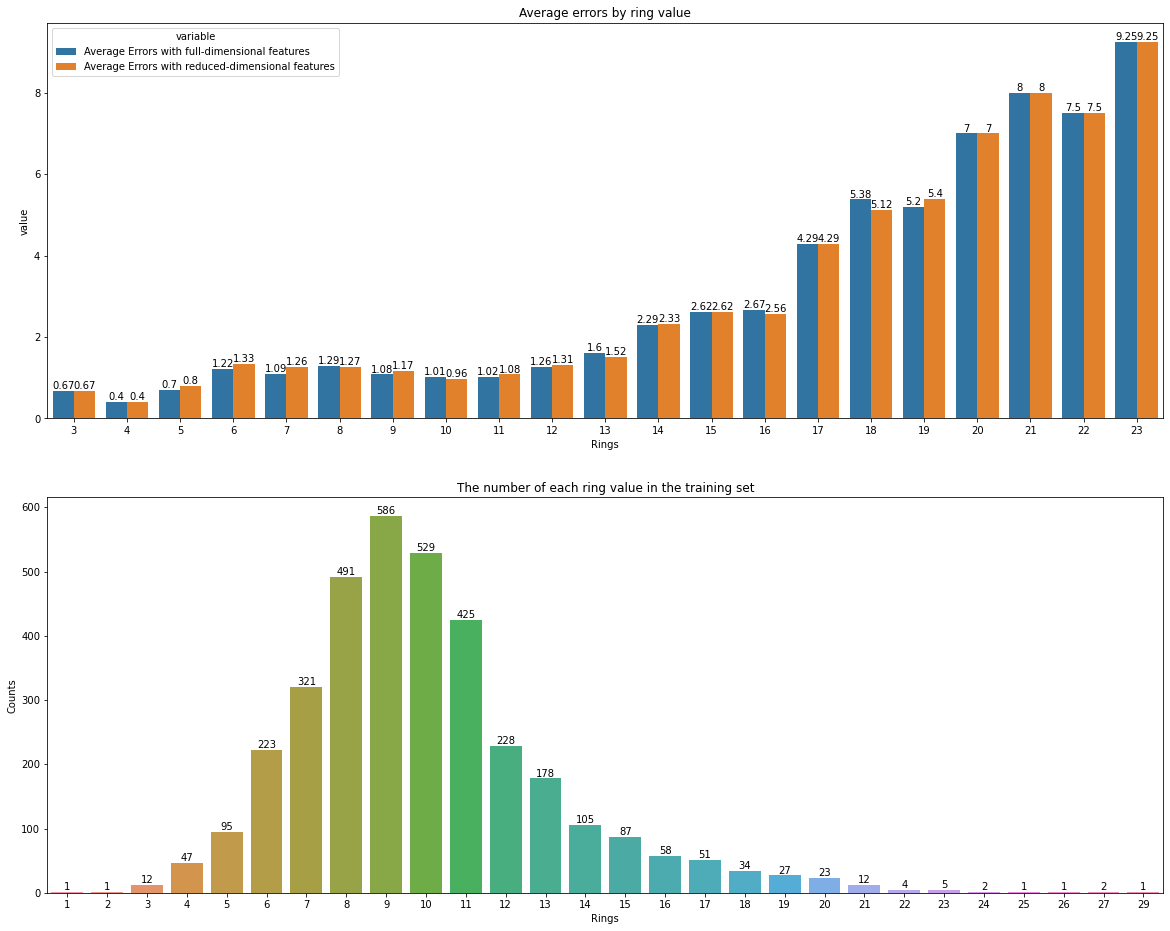

In [30]:
# caculate errors for each ring value and create a dataframe
errors = abs(y_test_abalone - rnd_pred)
errors_re = abs(y_test_abalone - rnd_pred_re)
df_errors = pd.DataFrame({'Rings':y_test_abalone, 'Errors':errors, 'Errors_re':errors_re})

# group the dataframe by ring values and caculate average errors for each unique ring value
df_avg_errors = pd.DataFrame(df_errors.groupby('Rings', as_index=False)[['Errors', 'Errors_re']].mean(
).values.round(2), columns=['Rings', 'Average Errors with full-dimensional features', 'Average Errors with reduced-dimensional features'])
df_avg_errors['Rings'] = df_avg_errors['Rings'].astype(int)
df_avg_errors = df_avg_errors.melt(id_vars='Rings')

# caculate the number of each ring value in the training set
df_rings = pd.DataFrame({'Rings':y_train_abalone}).value_counts().to_frame('Counts')
df_rings.reset_index(inplace=True)
df_rings = df_rings.rename(columns={'index': 'Rings'})


fig, axes = plt.subplots(2,1, figsize=(20,16))

# draw a barplot to see the relationship between average errors and ring values.
ax1 = sns.barplot(ax=axes[0], data=df_avg_errors, x='Rings',
                   y='value', hue='variable')
ax1.bar_label(ax1.containers[0])
ax1.bar_label(ax1.containers[1])
axes[0].set_title('Average errors by ring value')



# draw a barplot to see the number of each ring value
ax2 = sns.barplot(ax=axes[1], data=df_rings, x='Rings', y='Counts')
axes[1].set_title('The number of each ring value in the training set')
ax2.bar_label(ax2.containers[0])
plt.show()

From the first barplot we can see that the average errors of each ring value predicted by each model are very similar. In addition, with the increase of the ring value, the average error tend to become larger, which means large ring values tend to have large average errors. 

From the second plot we can see that smaller and larger ring values have less training instances. 

 - For larger ring values, the number of training instances are small while the prediction error tend to be large. For example, for ring values in `18-23`, the number of training instances of each ring value is all below `50` while the average errors of each ring value is all bigger than `5` for both models.
  
 - For smaller ring values, although the number of training instances are relatively small, the prediction error also tend to be small. For example, for ring values in `3-5`. the number of training instances of each ring value is all below `100` while the average errors of each ring value is all below `1` for both models.

To summarize, for relatively smaller ring values, the average error tend to be small. For relatively larger ring values, when the number of training instances is small, the average error tend to be large.

### Section 6 Bagging regressor

Use `SVR()` as the base estimator. Set `kernel=rbf` to build rbf model. Set `C=500` to increase the range of error tolerance for data points in order to avoid overfitting issue and increase the prediction performance.

Build and train the Bagging regressor model with the same parameters as parameters set in Random Forest regressor.

In [31]:
# train the model
bag_reg = BaggingRegressor(base_estimator=SVR(kernel='rbf', C=500), n_estimators=500, random_state=42, bootstrap=True, max_samples=1000).fit(X_train_abalone, y_train_abalone)

In [32]:
bag_pred = bag_reg.predict(X_test_abalone)
bag_pred = [int(round(num,0)) for num in bag_pred]
# caculate RMSE for the bag regressor model
rmse_bag = mean_squared_error(y_test_abalone, bag_pred, squared=False)
print('RMSE of the Bagging regressor: '+str(rmse_bag))


RMSE of the Bagging regressor: 2.1052830940044895


We can see the RMSE of the bag regressor model is a bit lower than that of the random forest regressor model.

As there are too many test instances in the dataset, we decided to use `histplot` to see the distribution of the predicted ring values versus that of the ground truth ring values in general. The x axis is the ring value and the y axis is the value count of ring value. 

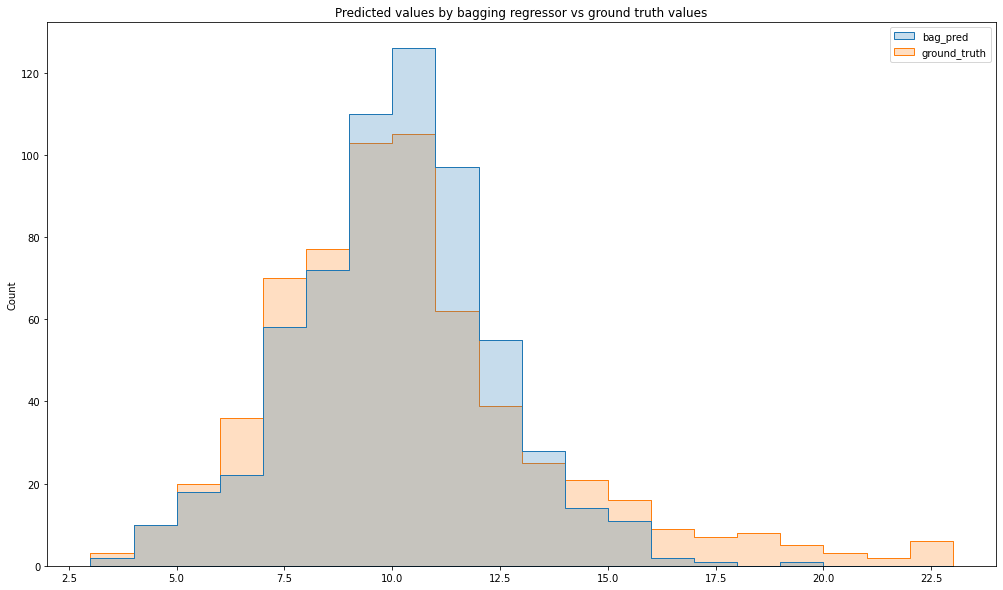

In [33]:
df_bag_pred = pd.DataFrame(
    {'bag_pred': bag_pred, 'ground_truth': y_test_abalone}).reset_index(drop=True)

plt.figure(figsize=(17, 10))
sns.histplot(data=df_bag_pred, bins=20, element="step")
plt.title('Predicted values by bagging regressor vs ground truth values')
plt.show()


From the output graph we can see that both of them are centrally distributed and their distributions mostly overlap, which means the model can generally perform predictions well on this dataset.

The number of predicted ring values in `9-13` is more than that of the ground truth ring values, while there are fewer or simply do not exist for predicted ring values in `16-23`. This means more errors may exist in those areas.

### Section 7 

### 7.1 Compare the performance 

Caculating RMSE and MAE to compare the performance of the first Random Forest regressor with that of the Bagging regressor.

In [34]:
# compute MAE value for both models
mae_bag = mean_absolute_error(y_test_abalone, bag_pred)

rmse_list = [rmse_rnd, rmse_bag]
mae_list = [mae_rnd, mae_bag]
pd.DataFrame(data = {'RMSE':rmse_list, 'MAE':mae_list}, index=['Random Forest regressor', 'Bagging regressor'])

,RMSE,MAE
Random Forest regressor,2.157292,1.451356
Bagging regressor,2.105283,1.395534


We can see that the RMSE and MAE of Random Forest regressor are all slightly higher than that of Bagging regressor, which means Bagging regressor has higher performance.

### 7.2 Compute the average error
Compare the average error of bagging regressor with that of RF regressor for each test instances.

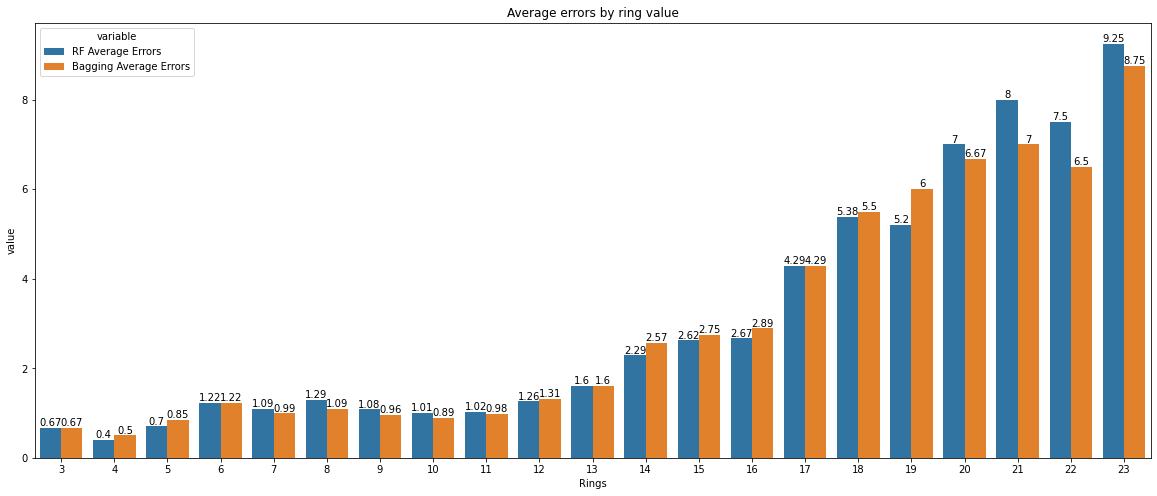

In [35]:
# caculate errors for each ring value and create a dataframe
errors_bag = abs(y_test_abalone - bag_pred)
df_errors_bag_rf = pd.DataFrame(
    {'Rings': y_test_abalone, 'Errors': errors, 'Errors_bag': errors_bag})


# group the dataframe by ring values and caculate average errors for each unique ring value
df_avg_errors_bag_rf = pd.DataFrame(df_errors_bag_rf.groupby('Rings', as_index=False)[['Errors', 'Errors_bag']].mean(
).values.round(2), columns=['Rings', 'RF Average Errors', 'Bagging Average Errors'])
df_avg_errors_bag_rf['Rings'] = df_avg_errors_bag_rf['Rings'].astype(int)
df_avg_errors_bag_rf = df_avg_errors_bag_rf.melt(id_vars='Rings')


plt.figure(figsize=(20, 8))
# draw a barplot to see the relationship between average errors and ring values.
ax11 = sns.barplot(data=df_avg_errors_bag_rf, x='Rings',
                  y='value', hue='variable')
ax11.bar_label(ax11.containers[0])
ax11.bar_label(ax11.containers[1])
plt.title('Average errors by ring value')
plt.show()


we can see that the average errors of each ring value predicted by each model are very similar, which means the average error of each ring value predicted by bagging regressor has the similar distribution pattern with that of the RF regressor.
